In [1]:
!pip install nibabel matplotlib numpy


In [2]:
!pip install tensorflow


In [3]:
!unzip "/content/drive/MyDrive/BraTS2020_training_data.zip" -d /content/brats_raw


Streaming output truncated to the last 5000 lines.
  inflating: /content/brats_raw/content/data/volume_70_slice_63.h5  
  inflating: /content/brats_raw/content/data/volume_70_slice_64.h5  
  inflating: /content/brats_raw/content/data/volume_70_slice_65.h5  
  inflating: /content/brats_raw/content/data/volume_70_slice_66.h5  
  inflating: /content/brats_raw/content/data/volume_70_slice_67.h5  
  inflating: /content/brats_raw/content/data/volume_70_slice_68.h5  
  inflating: /content/brats_raw/content/data/volume_70_slice_69.h5  
  inflating: /content/brats_raw/content/data/volume_70_slice_7.h5  
  inflating: /content/brats_raw/content/data/volume_70_slice_70.h5  
  inflating: /content/brats_raw/content/data/volume_70_slice_71.h5  
  inflating: /content/brats_raw/content/data/volume_70_slice_72.h5  
  inflating: /content/brats_raw/content/data/volume_70_slice_73.h5  
  inflating: /content/brats_raw/content/data/volume_70_slice_74.h5  
  inflating: /content/brats_raw/content/data/volume_7

In [4]:
!find /content/brats_raw -maxdepth 2 -type d


/content/brats_raw
/content/brats_raw/content
/content/brats_raw/content/data


In [5]:
import h5py

h5_path = "/content/brats_raw/content/data/volume_100_slice_100.h5"

with h5py.File(h5_path, "r") as f:
    print(f.keys())


<KeysViewHDF5 ['image', 'mask']>


**Step 2️⃣ Load a small batch of slices**

In [6]:
import os
import h5py
import numpy as np

data_dir = "/content/brats_raw/content/data"
files = sorted([f for f in os.listdir(data_dir) if f.endswith(".h5")])

N = 50  # small subset for now
files = files[:N]

X = []
Y = []

for fname in files:
    with h5py.File(os.path.join(data_dir, fname), "r") as f:
        img = f["image"][:]
        mask = f["mask"][:]
        X.append(img)
        Y.append(mask)

X = np.array(X)
Y = np.array(Y)

print("X shape:", X.shape)
print("Y shape:", Y.shape)


X shape: (50, 240, 240, 4)
Y shape: (50, 240, 240, 3)


**Step 3️⃣ Normalize & add channel dimension**

In [7]:
# Normalize images to 0–1
X = X.astype("float32")
X = (X - X.min()) / (X.max() - X.min() + 1e-8)

# Masks to 0/1
Y = (Y > 0).astype("float32")

# Add channel dimension
X = X[..., np.newaxis]
Y = Y[..., np.newaxis]

print("After reshape:")
print("X:", X.shape)
print("Y:", Y.shape)


After reshape:
X: (50, 240, 240, 4, 1)
Y: (50, 240, 240, 3, 1)


**Step 4️⃣ Train/Validation split**

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, Y_train.shape)
print("Val:", X_val.shape, Y_val.shape)


Train: (40, 240, 240, 4, 1) (40, 240, 240, 3, 1)
Val: (10, 240, 240, 4, 1) (10, 240, 240, 3, 1)


In [9]:
# If your X has shape (N, H, W, 4, 1) or (N, H, W, 4)
# Convert it to (N, H, W, 1)

if X_train.ndim == 5:
    X_train = X_train[..., 0]   # drop the extra modality dimension
    X_val   = X_val[..., 0]

if Y_train.ndim == 5:
    Y_train = Y_train[..., 0]
    Y_val   = Y_val[..., 0]

print("Fixed shapes:")
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)


Fixed shapes:
X_train: (40, 240, 240, 4)
Y_train: (40, 240, 240, 3)


**Define a small U-Net**

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def unet(input_shape=(128, 128, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(16, 3, activation="relu", padding="same")(inputs)
    c1 = Conv2D(16, 3, activation="relu", padding="same")(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation="relu", padding="same")(p1)
    c2 = Conv2D(32, 3, activation="relu", padding="same")(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(64, 3, activation="relu", padding="same")(p2)
    c3 = Conv2D(64, 3, activation="relu", padding="same")(c3)

    # Decoder
    u2 = UpSampling2D()(c3)
    m2 = Concatenate()([u2, c2])
    c4 = Conv2D(32, 3, activation="relu", padding="same")(m2)
    c4 = Conv2D(32, 3, activation="relu", padding="same")(c4)

    u1 = UpSampling2D()(c4)
    m1 = Concatenate()([u1, c1])
    c5 = Conv2D(16, 3, activation="relu", padding="same")(m1)
    c5 = Conv2D(16, 3, activation="relu", padding="same")(c5)

    outputs = Conv2D(1, 1, activation="sigmoid")(c5)

    model = Model(inputs, outputs)
    return model

model = unet(input_shape=X_train.shape[1:])
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 240, 240,  │        592 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 240, 240,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 120, 120,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 120, 120,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 120, 120,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 60, 60,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 60, 60,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 120, 120,  │          0 │ conv2d_5[0][0]    │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 120, 120,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 120, 120,  │     27,680 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 120, 120,  │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 240, 240,  │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 240, 240,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 48)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 240, 240,  │      6,928 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 240, 240,  │      2,320 │ conv2d_8[0][0]  

 Total params: 118,417 (462.57 KB)

 Trainable params: 118,417 (462.57 KB)

 Non-trainable params: 0 (0.00 B)

**Train the model (few epochs)**

In [11]:
print("X_train:", X_train.shape, X_train.dtype)
print("Y_train:", Y_train.shape, Y_train.dtype)

print("X_val:", X_val.shape)
print("Y_val:", Y_val.shape)

import numpy as np
print("NaN in X_train?", np.isnan(X_train).any())
print("NaN in Y_train?", np.isnan(Y_train).any())
print("Unique Y_train:", np.unique(Y_train))



X_train: (40, 240, 240, 4) float32
Y_train: (40, 240, 240, 3) float32
X_val: (10, 240, 240, 4)
Y_val: (10, 240, 240, 3)
NaN in X_train? False
NaN in Y_train? False
Unique Y_train: [0. 1.]


In [12]:
import os, h5py, numpy as np
from sklearn.model_selection import train_test_split

data_dir = "/content/brats_raw/content/data"
files = sorted([f for f in os.listdir(data_dir) if f.endswith(".h5")])[:30]  # smaller set

X, Y = [], []

for fname in files:
    with h5py.File(os.path.join(data_dir, fname), "r") as f:
        img = f["image"][:]
        mask = f["mask"][:]

        # force single channel
        if img.ndim == 3:
            img = img[..., 0]
        if mask.ndim == 3:
            mask = mask[..., 0]

        X.append(img)
        Y.append(mask)

X = np.array(X, dtype="float32")
Y = np.array(Y, dtype="float32")

# normalize X
X = (X - X.min()) / (X.max() - X.min() + 1e-8)

# binarize Y
Y = (Y > 0).astype("float32")

# add channel dim
X = X[..., np.newaxis]
Y = Y[..., np.newaxis]

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Final shapes:", X_train.shape, Y_train.shape)



Final shapes: (24, 240, 240, 1) (24, 240, 240, 1)


In [32]:
import os, h5py

data_dir = "/content/brats_raw/content/data"
files = sorted([f for f in os.listdir(data_dir) if f.endswith(".h5")])

tumor_files = []
non_tumor_files = []

for fname in files:
    with h5py.File(os.path.join(data_dir, fname), "r") as f:
        mask = f["mask"][:]
        if mask.sum() > 10 and len(tumor_files) < 50:
            tumor_files.append(fname)
        elif mask.sum() <= 10 and len(non_tumor_files) < 30:
            non_tumor_files.append(fname)

    # stop early when we have enough
    if len(tumor_files) >= 50 and len(non_tumor_files) >= 30:
        break

print("Tumor files:", len(tumor_files))
print("Non-tumor files:", len(non_tumor_files))


Tumor files: 50
Non-tumor files: 30


In [33]:
import os, h5py, numpy as np
from sklearn.model_selection import train_test_split

data_dir = "/content/brats_raw/content/data"

selected_files = tumor_files + non_tumor_files  # 60 files total

X, Y = [], []

for fname in selected_files:
    with h5py.File(os.path.join(data_dir, fname), "r") as f:
        img = f["image"][:]
        mask = f["mask"][:]

        # force single channel
        if img.ndim == 3:
            img = img[..., 0]
        if mask.ndim == 3:
            mask = mask[..., 0]

        X.append(img)
        Y.append(mask)

X = np.array(X, dtype="float32")
Y = np.array(Y, dtype="float32")

# normalize images
X = (X - X.min()) / (X.max() - X.min() + 1e-8)

# binarize masks
Y = (Y > 0).astype("float32")

# add channel dimension
X = X[..., np.newaxis]
Y = Y[..., np.newaxis]

# split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape)
print("Tumor in Train:", sum([Y_train[i].sum() > 10 for i in range(len(Y_train))]))
print("Tumor in Val:", sum([Y_val[i].sum() > 10 for i in range(len(Y_val))]))


Train: (64, 240, 240, 1) Val: (16, 240, 240, 1)
Tumor in Train: 28
Tumor in Val: 10


In [34]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=2
)



Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9904 - loss: 0.0281 - val_accuracy: 0.9878 - val_loss: 0.0317
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9911 - loss: 0.0252 - val_accuracy: 0.9878 - val_loss: 0.0298
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9920 - loss: 0.0226 - val_accuracy: 0.9878 - val_loss: 0.0284
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9919 - loss: 0.0264 - val_accuracy: 0.9878 - val_loss: 0.0292
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9918 - loss: 0.0211 - val_accuracy: 0.9878 - val_loss: 0.0295
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9923 - loss: 0.0243 - val_accuracy: 0.9878 - val_loss: 0.0283
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9922 - loss: 0.0218 - val_accuracy: 0.9878 - val_loss: 0.0251
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9920 - loss: 0.0179 - val_accuracy: 0.9878 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


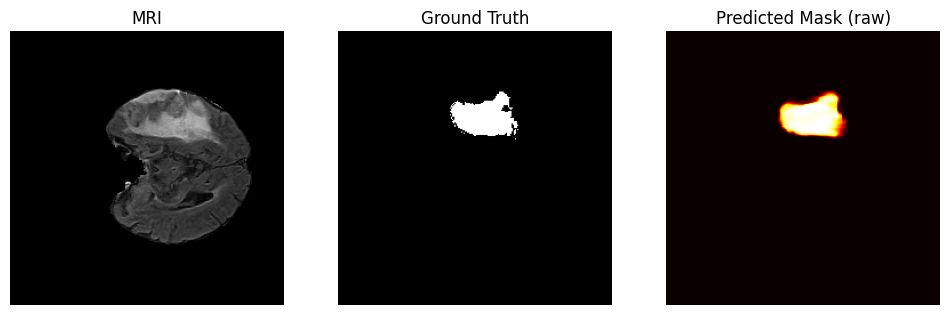

In [35]:
tumor_indices = [i for i in range(len(Y_val)) if Y_val[i].sum() > 10]
idx = tumor_indices[0]

pred = model.predict(X_val[idx:idx+1])[0, :, :, 0]

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(X_val[idx].squeeze(), cmap="gray")
plt.title("MRI")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(Y_val[idx].squeeze(), cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="hot")
plt.title("Predicted Mask (raw)")
plt.axis("off")

plt.show()


In [19]:
for layer in model.layers:
    print(layer.name, layer.__class__.__name__)


input_layer InputLayer
conv2d Conv2D
conv2d_1 Conv2D
max_pooling2d MaxPooling2D
conv2d_2 Conv2D
conv2d_3 Conv2D
max_pooling2d_1 MaxPooling2D
conv2d_4 Conv2D
conv2d_5 Conv2D
up_sampling2d UpSampling2D
concatenate Concatenate
conv2d_6 Conv2D
conv2d_7 Conv2D
up_sampling2d_1 UpSampling2D
concatenate_1 Concatenate
conv2d_8 Conv2D
conv2d_9 Conv2D
conv2d_10 Conv2D


In [37]:
def grad_cam_unet_maxpixel(model, img_tensor, layer_name="conv2d_10"):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = tf.reduce_max(predictions)  # focus on strongest response

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap.numpy()
    heatmap -= heatmap.min()
    heatmap /= (heatmap.max() + 1e-8)

    return heatmap


In [38]:
# Create a model that outputs pre-sigmoid activations
pre_sigmoid_model = tf.keras.models.Model(
    model.inputs,
    model.layers[-1].input  # input to the final Conv2D(1,1, sigmoid)
)

def grad_cam_unet_presigmoid(model, img_tensor, layer_name="conv2d_10"):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, pre_sigmoid_model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, pre_sigmoid = grad_model(img_tensor)
        loss = tf.reduce_max(pre_sigmoid)  # stronger gradients

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap.numpy()
    heatmap -= heatmap.min()
    heatmap /= (heatmap.max() + 1e-8)

    return heatmap


(np.float64(-0.5), np.float64(239.5), np.float64(239.5), np.float64(-0.5))

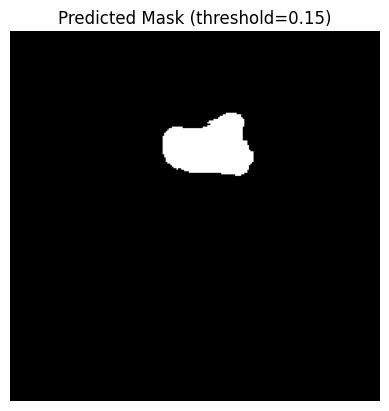

In [39]:
plt.imshow(pred > 0.15, cmap="gray")
plt.title("Predicted Mask (threshold=0.15)")
plt.axis("off")


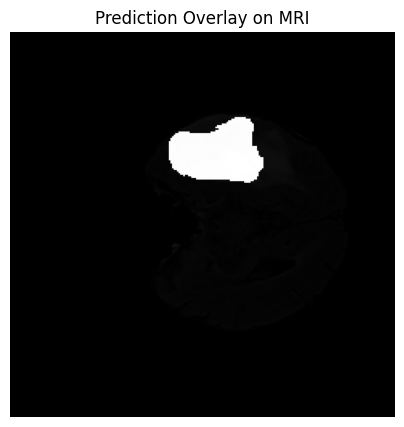

In [40]:
overlay = X_val[idx].squeeze().copy()
overlay[pred > 0.15] = overlay[pred > 0.15] * 0.3 + 0.7  # brighten predicted areas

plt.figure(figsize=(5,5))
plt.imshow(overlay, cmap="gray")
plt.title("Prediction Overlay on MRI")
plt.axis("off")
plt.show()


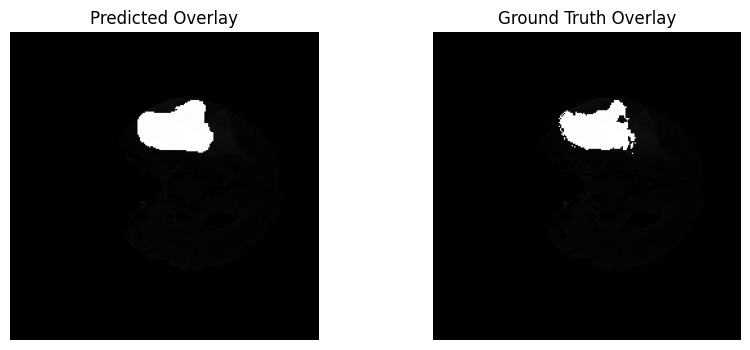

In [41]:
gt_overlay = X_val[idx].squeeze().copy()
gt_overlay[Y_val[idx].squeeze() > 0] = gt_overlay[Y_val[idx].squeeze() > 0] * 0.3 + 0.7

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(overlay, cmap="gray")
plt.title("Predicted Overlay")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(gt_overlay, cmap="gray")
plt.title("Ground Truth Overlay")
plt.axis("off")

plt.show()


In [42]:
plt.imsave("pred_overlay.png", overlay, cmap="gray")
plt.imsave("gt_overlay.png", gt_overlay, cmap="gray")


In [43]:
import numpy as np

def dice_coef(y_true, y_pred, eps=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2 * intersection + eps) / (np.sum(y_true_f) + np.sum(y_pred_f) + eps)

def iou_score(y_true, y_pred, eps=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + eps) / (union + eps)

# Predict on validation set
Y_val_pred = model.predict(X_val)

# Binarize predictions
Y_val_pred_bin = (Y_val_pred > 0.15).astype(np.float32)

dice_scores = []
iou_scores = []
pixel_accs = []

for i in range(len(Y_val)):
    dice_scores.append(dice_coef(Y_val[i], Y_val_pred_bin[i]))
    iou_scores.append(iou_score(Y_val[i], Y_val_pred_bin[i]))
    pixel_accs.append(np.mean(Y_val_pred_bin[i] == Y_val[i]))

print("Mean Dice:", np.mean(dice_scores))
print("Mean IoU:", np.mean(iou_scores))
print("Mean Pixel Accuracy:", np.mean(pixel_accs))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Mean Dice: 0.5492763
Mean IoU: 0.49307102
Mean Pixel Accuracy: 0.9953993055555557


In [28]:
tumor_idxs = [i for i in range(len(Y_val)) if Y_val[i].sum() > 10]

dice_tumor = [dice_coef(Y_val[i], Y_val_pred_bin[i]) for i in tumor_idxs]
iou_tumor = [iou_score(Y_val[i], Y_val_pred_bin[i]) for i in tumor_idxs]

print("Tumor-only Dice:", np.mean(dice_tumor))
print("Tumor-only IoU:", np.mean(iou_tumor))
print("Tumor slices evaluated:", len(tumor_idxs))


Tumor-only Dice: 0.06620026
Tumor-only IoU: 0.0348055
Tumor slices evaluated: 2


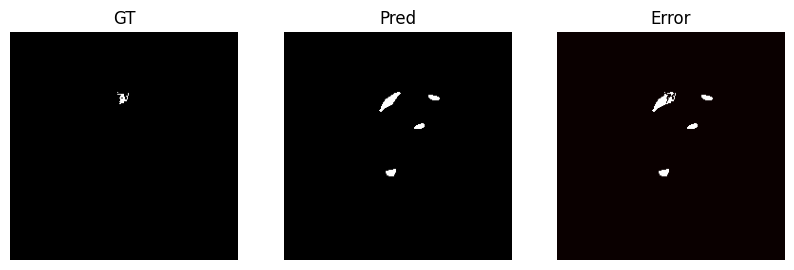

In [29]:
i = tumor_idxs[0]
plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.imshow(Y_val[i].squeeze(), cmap="gray"); plt.title("GT"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(Y_val_pred_bin[i].squeeze(), cmap="gray"); plt.title("Pred"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow((Y_val[i] != Y_val_pred_bin[i]).squeeze(), cmap="hot"); plt.title("Error"); plt.axis("off")
plt.show()


In [45]:
thresholds = np.linspace(0.05, 0.4, 8)
best_t, best_d = 0, 0

for t in thresholds:
    Y_bin = (Y_val_pred > t).astype(np.float32)
    d = np.mean([dice_coef(Y_val[i], Y_bin[i]) for i in tumor_idxs])
    if d > best_d:
        best_d, best_t = d, t

print("Best threshold:", best_t, "Best tumor-only Dice:", best_d)


Best threshold: 0.35000000000000003 Best tumor-only Dice: 0.9218874


(np.float64(-0.5), np.float64(239.5), np.float64(239.5), np.float64(-0.5))

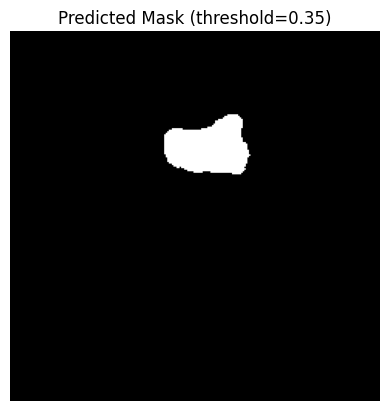

In [46]:
plt.imshow(pred > best_t, cmap="gray")
plt.title(f"Predicted Mask (threshold={best_t:.2f})")
plt.axis("off")


(np.float64(-0.5), np.float64(239.5), np.float64(239.5), np.float64(-0.5))

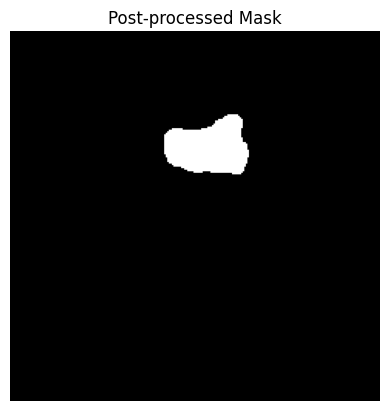

In [47]:
import cv2
import numpy as np

bin_pred = (pred > best_t).astype(np.uint8)

kernel = np.ones((5,5), np.uint8)
bin_pred = cv2.morphologyEx(bin_pred, cv2.MORPH_OPEN, kernel)
bin_pred = cv2.morphologyEx(bin_pred, cv2.MORPH_CLOSE, kernel)

plt.imshow(bin_pred, cmap="gray")
plt.title("Post-processed Mask")
plt.axis("off")


In [48]:
Y_val_pred = model.predict(X_val)
Y_val_pred_bin = (Y_val_pred > best_t).astype(np.float32)

tumor_idxs = [i for i in range(len(Y_val)) if Y_val[i].sum() > 10]

dice_tumor = [dice_coef(Y_val[i], Y_val_pred_bin[i]) for i in tumor_idxs]
iou_tumor = [iou_score(Y_val[i], Y_val_pred_bin[i]) for i in tumor_idxs]

print("Tumor-only Dice:", np.mean(dice_tumor))
print("Tumor-only IoU:", np.mean(iou_tumor))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Tumor-only Dice: 0.7951895
Tumor-only IoU: 0.71556824


**GRAD_CAM_SETUP**

In [49]:
import numpy as np

# pick the val slice with highest total prediction (model "cares" most about this one)
scores = [model.predict(X_val[i:i+1]).sum() for i in range(len(X_val))]
idx = int(np.argmax(scores))

img = X_val[idx:idx+1]
gt = Y_val[idx]
pred = model.predict(img)[0, :, :, 0]

print("Chosen idx:", idx, "GT tumor pixels:", gt.sum(), "Pred max:", pred.max())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Chosen idx: 3 GT tumor pixels: 1531.0 Pred max: 0.99982095


In [50]:
import tensorflow as tf

def grad_cam_unet_maxpixel(model, img_tensor, layer_name="conv2d_10"):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = tf.reduce_max(predictions)  # focus on strongest response

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap.numpy()
    heatmap -= heatmap.min()
    heatmap /= (heatmap.max() + 1e-8)

    return heatmap


In [51]:
heatmap = grad_cam_unet_maxpixel(model, img, layer_name="conv2d_10")


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 240, 240, 1))
  warnings.warn(msg)


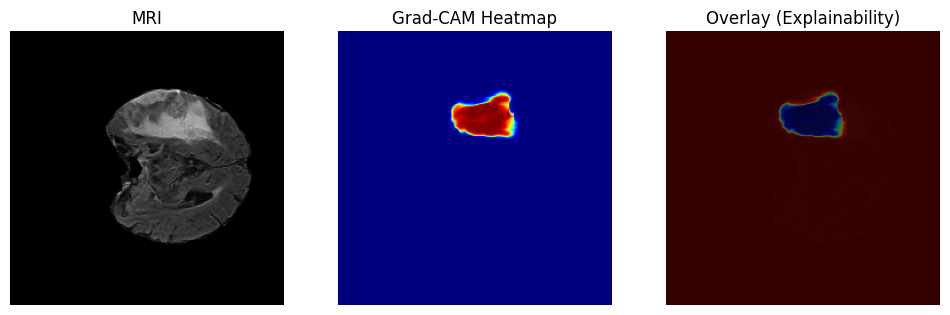

In [52]:
import cv2
import matplotlib.pyplot as plt

# Resize heatmap to match image
heatmap_resized = cv2.resize(heatmap, (img.shape[2], img.shape[1]))

# Prepare MRI for overlay
mri = img[0, :, :, 0]
mri_rgb = np.stack([mri, mri, mri], axis=-1)

# Colorize heatmap
heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET) / 255.0

# Overlay
overlay = np.clip(0.6 * mri_rgb + 0.4 * heatmap_color, 0, 1)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(mri, cmap="gray")
plt.title("MRI")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap_resized, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay (Explainability)")
plt.axis("off")

plt.show()


In [54]:
import numpy as np

# Predict once for val set
Y_val_pred = model.predict(X_val)
Y_val_pred_bin = (Y_val_pred > 0.15).astype(np.float32)

# Dice per slice
dice_per_slice = []
tumor_areas = []

for i in range(len(Y_val)):
    area = Y_val[i].sum()
    tumor_areas.append(area)
    if area > 10:
        dice = dice_coef(Y_val[i], Y_val_pred_bin[i])
    else:
        dice = np.nan
    dice_per_slice.append(dice)

tumor_idxs = [i for i in range(len(Y_val)) if tumor_areas[i] > 10]

# 1) Small tumor case
small_tumor_idx = min(tumor_idxs, key=lambda i: tumor_areas[i])

# 2) Complex tumor case (largest area)
complex_tumor_idx = max(tumor_idxs, key=lambda i: tumor_areas[i])

# 3) Failure case (worst Dice among tumor slices)
failure_idx = min(tumor_idxs, key=lambda i: dice_per_slice[i])

small_tumor_idx, complex_tumor_idx, failure_idx


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


(9, 3, 9)

In [60]:
# Identify non-tumor indices in validation
non_tumor_idxs = [i for i in range(len(Y_val)) if Y_val[i].sum() <= 10]

# Sort tumor indices by area
tumor_sorted_by_area = sorted(tumor_idxs, key=lambda i: tumor_areas[i])

# Pick 10 small tumors
small_idxs = tumor_sorted_by_area[:10]

# Pick 10 complex tumors (largest)
complex_idxs = tumor_sorted_by_area[-10:]

# Pick 5 failure cases (worst Dice), excluding already picked
remaining_tumors = [i for i in tumor_idxs if i not in small_idxs + complex_idxs]
failure_idxs = sorted(remaining_tumors, key=lambda i: dice_per_slice[i])[:5]

# Pick 5 non-tumor cases (no tumor GT)
non_tumor_selected = non_tumor_idxs[:5]

# Final unique set (30 cases)
selected_idxs = small_idxs + complex_idxs + failure_idxs + non_tumor_selected

print("Total selected:", len(selected_idxs))
print("Unique:", len(set(selected_idxs)))


Total selected: 25
Unique: 15


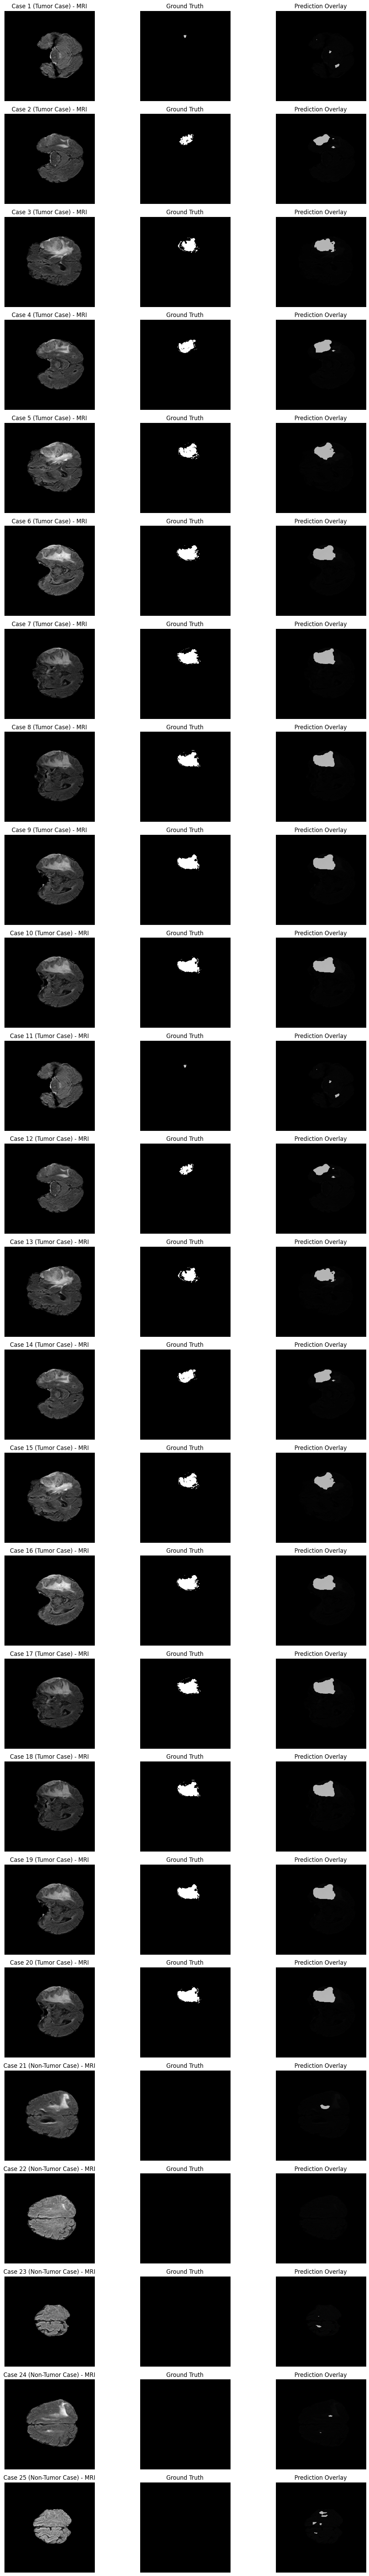

In [61]:
plt.figure(figsize=(12, 90))

for r, idx in enumerate(selected_idxs):
    mri = X_val[idx].squeeze()
    gt = Y_val[idx].squeeze()
    pred = Y_val_pred[idx].squeeze()
    ov = overlay_pred(mri, pred, thr=0.15)

    label = "Non-Tumor Case" if Y_val[idx].sum() <= 10 else "Tumor Case"

    plt.subplot(30, 3, r*3 + 1)
    plt.imshow(mri, cmap="gray")
    plt.title(f"Case {r+1} ({label}) - MRI")
    plt.axis("off")

    plt.subplot(30, 3, r*3 + 2)
    plt.imshow(gt, cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(30, 3, r*3 + 3)
    plt.imshow(ov, cmap="gray")
    plt.title("Prediction Overlay")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [63]:
# Predict on validation
Y_val_pred = model.predict(X_val)

# Binarize predictions (use your tuned threshold)
THR = 0.15
Y_val_pred_bin = (Y_val_pred > THR).astype(np.float32)

# Pixel accuracy over validation set
pixel_acc = np.mean(Y_val_pred_bin == Y_val)
print("Pixel Accuracy:", pixel_acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Pixel Accuracy: 0.9953993055555556


In [64]:
dice_scores = []
iou_scores = []

for i in range(len(Y_val)):
    if Y_val[i].sum() > 10:  # tumor slices only (fair evaluation)
        dice_scores.append(dice_coef(Y_val[i], Y_val_pred_bin[i]))
        iou_scores.append(iou_score(Y_val[i], Y_val_pred_bin[i]))

print("Tumor-only Mean Dice:", np.mean(dice_scores))
print("Tumor-only Mean IoU:", np.mean(iou_scores))
print("Tumor slices evaluated:", len(dice_scores))


Tumor-only Mean Dice: 0.778842
Tumor-only Mean IoU: 0.68891364
Tumor slices evaluated: 10
